# TimeShop Demonstration

In [1]:
#general
import sys

#audio
from IPython.display import Audio
import scipy.io.wavfile as wf

#data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# timeatlas
from timeatlas import TimeSeriesDarts

#ploting
import matplotlib.pyplot as plt
plt.style.use('seaborn')

### Implemented Functions

###### Selectors

|     Selector     |                                 Description                                 | 
|------------------|-----------------------------------------------------------------------------|
|select            | Selecting a part of  a time series                                          |
|select_random     | Selecting a part of  a time seires at random                                |
|threshold_search  | Selecting every part of  a time series that follows given parameters        |

##### Manipulators

| Manipulator        | Description                                   |
|--------------------|-----------------------------------------------|
| flatten            | Filling the selected part with flat value     |
| create_white_noise | Filling the selected part with white noise    |
| create_trend       | Filling the selected part with trend          |
| spiking            | Filling the selected part with a spike        |
| time_shifting      | Shifting the timestamp index of the selection |
| hard_knee          | Hard Knee compression of the selected part    |
| soft_knee          | Not Implemented                               |

###### Operators

| Operator | Description                                                   |
|----------|---------------------------------------------------------------|
| add      | Adding the value of selection and original together           |
| multiply | Multiply the value of selection and original together         |
| replace  | Replace the original part with the selection                  |
| insert   | Insert the selection at its timestamps and shift the original |
| crop     | Remove the part between the given timestamps                  |

##### Typical workflow


                   when         what       how
                    |            |         |
    ts.edit().<selector>().<verb>().<executor>()
    


1. Creating the TimeShop-object
2. Selecting what part do we want to work on? -> WHEN?
3. What do we do with this selection? -> WHAT?
4. How does the selection go back into the original? -> HOW?
    

### Loading the Data

For this demonstration we are loading the famous auditory Illusion.

Later we will apply a few common audio errors to the file using the TimeShop() object from the TimeAtlas library.

In [2]:
sound_file = './Laurel.wav'
Audio(sound_file)

Now we convert the audiofile into a pandas.DataFrame(). Further we are only using one channel of the audio, since for the demonstration a multivariate anomaly injection is not needed.

It is noteworthy that the timestamps within the DataFrame have e delta of 1 second. The audiofile is much shorter but the underlying data object from darts is not handling the rate of the audiofile well.

In [3]:
rate, data = wf.read(sound_file)

/Users/lorenz/.local/share/virtualenvs/timeatlas-kzsAXcI_/lib/python3.7/site-packages/ipykernel_launcher.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  """Entry point for launching an IPython kernel.


In [4]:
df = pd.DataFrame(data=data[:,0], columns=["Channel 1"])
df.index = pd.to_datetime(pd.date_range(start = '2021-08-13 00:00:00', periods=len(df), freq='s'))

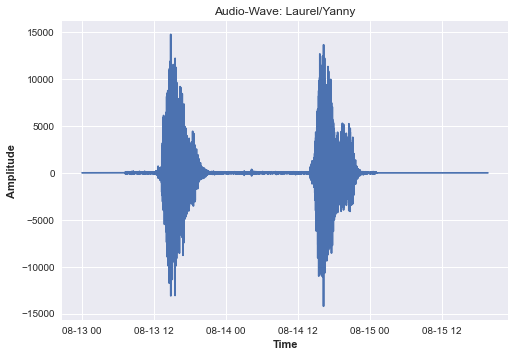

In [5]:
plt.plot(df)
plt.title("Audio-Wave: Laurel/Yanny")
plt.xlabel("Time")
plt.ylabel("Amplitude");


In [6]:
ts = TimeSeriesDarts.from_dataframe(df)

A little helper function to save the changed TimeSeries object into a audiofile. 

- ts: TimeSeries object
- name: filename

In [7]:
def create_wav(ts, name): 
    tmp = ts.pd_dataframe()["Channel 1"].values.astype(np.int16)
    wf.write(rate=rate, data=tmp, filename=f"{name}.wav")

## Create Change Point

First we want to change the amplitue of the audio in a given strech of it to a fixed level.
The workflow is the following:

#### 1. We create a TimeShop() object

In [63]:
tss = ts.edit()

Plotting the time series is also easy

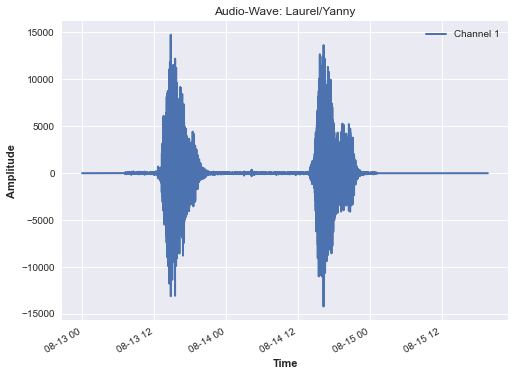

In [64]:
tss.plot()
plt.title("Audio-Wave: Laurel/Yanny")
plt.xlabel("Time")
plt.ylabel("Amplitude");


#### 2. We select a part of the original time series that we want to work on.

In [65]:
tss.select(other=ts, start_time='2021-08-13 09:00:00', end_time='2021-08-13 15:00:00')

#### 3. We transform the selected part to a flattened sigal at a fixed value (if no value is given the first value of the selected part is used)

In [66]:
tss.flatten(value=30000)

#### 4. We chose the mode on how we want to put the selected and modified part back into the time series

In [67]:
tss.replace()

Now we have a new time series with the modified part back integrated into it. The added part is automatially highlighted in red

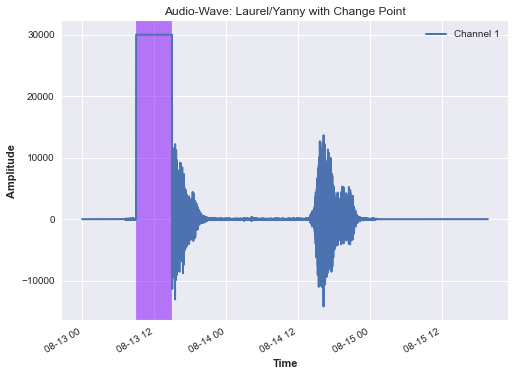

In [68]:
tss.plot()
plt.title("Audio-Wave: Laurel/Yanny with Change Point")
plt.xlabel("Time")
plt.ylabel("Amplitude");

In [69]:
create_wav(tss.extract(), "laurel_change_point")

In [70]:
sound_file = './laurel_change_point.wav'
Audio(sound_file)

## Create White Noise

Another very common problem with audio is a white noise. We can integrate this very easily using TimeShop(). Here we show the workflow of this process.

#### 1. We create a TimeShop() object

In [14]:
tss = ts.edit()

#### 2. We select a part of the original time series that we want to work on.

In [15]:
tss.select(other=tss.time_series, start_time='2021-08-13 12:00:00', end_time='2021-08-13 23:00:00')

#### 3. We transform the selected part to a white noise signal. We can either fix the mean $\mu$, if we do not select if the mean at every timestep t will be used. Additionally the standart diviation $\sigma$ has to be given.

In [16]:
tss.create_white_noise(mu=0, sigma=2000)

Here we can have a look at the selected and changed part.

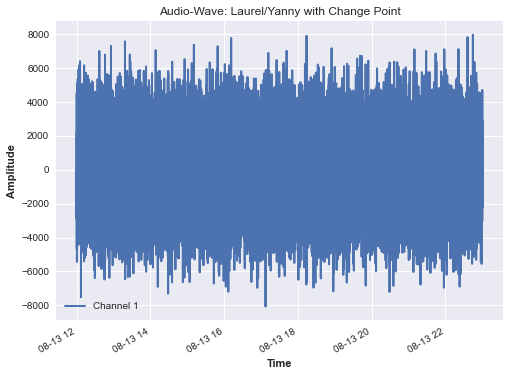

In [17]:
tss.clipboard_plot()
plt.title("Audio-Wave: Laurel/Yanny with Change Point")
plt.xlabel("Time")
plt.ylabel("Amplitude");

#### 4. We chose the mode on how we want to put the selected and modified part back into the time series. For white noise adding with add() is typical.

In [18]:
tss.add()

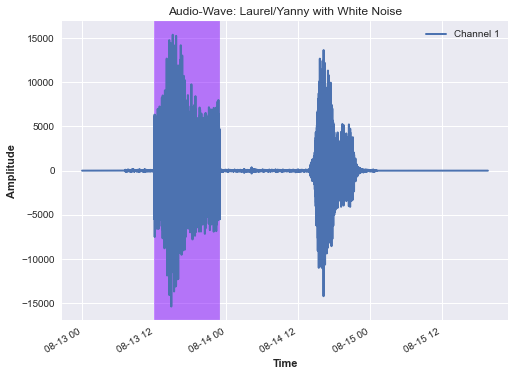

In [19]:
tss.plot()
plt.title("Audio-Wave: Laurel/Yanny with White Noise")
plt.xlabel("Time")
plt.ylabel("Amplitude");

The addition of white noise is not very visible in the plot. We can listen to the audio with the following commands:

In [20]:
create_wav(tss.extract(), "laurel_whitenoise")

In [21]:
sound_file = './laurel_whitenoise.wav'
Audio(sound_file)

## Clip-Sound at the Top

Audio compression is a classical problem. Here is the workflow for it.

#### 1. We create a TimeShop() object

In [22]:
tss = ts.edit()

#### 2. We select a part of the original time series that we want to work on. We use threshold_search() with the classical operators and a threshold value.

Note: This function is very slow. A faster version is in the works

In [23]:
tss.threshold_search(threshold=10000, operator=">")

#### 3. We transform the selected part to a flattened sigal at a fixed value. Here we not specify the value therefore the first value of each selected part is used.

In [24]:
tss.flatten(value=10000)

#### 4. We chose the mode on how we want to put the selected and modified part back into the time series.

In [25]:
tss.replace()

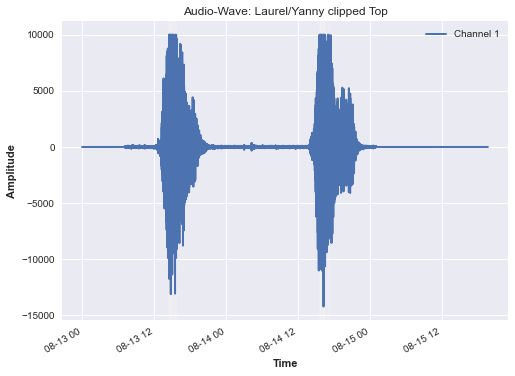

In [26]:
tss.plot()
plt.title("Audio-Wave: Laurel/Yanny clipped Top")
plt.xlabel("Time")
plt.ylabel("Amplitude");

In [27]:
create_wav(tss.extract(), "laurel_clip")

In [28]:
sound_file = './laurel_clip.wav'
Audio(sound_file)

## Create Demo for Spiking

#### 1. We create a TimeShop() object

In [29]:
tss = ts.edit()

#### 2. We select a part of the original time series.

In [30]:
tss.select(other=tss.time_series, start_time='2021-08-13 12:00:00', end_time='2021-08-13 23:00:01')

#### 3. We transform the selected part to a spike sigal. We have to set the maximum value and the mode how to approach it.

In [31]:
tss.spiking(spike_value=20000, mode='exp', p=2)

/Users/lorenz/Documents/timeatlas/src/timeatlas/manipulator/time_shop.py:411: UserWarning: Given TimeSeries to work on was even in length. To create a spike in the middle the stretch was shortened by 1.
  "Given TimeSeries to work on was even in length. To create a spike in the middle the stretch was shortened by 1.")


#### 4. We chose the mode on how we want to put the selected and modified part back into the time series.

In [32]:
tss.add()

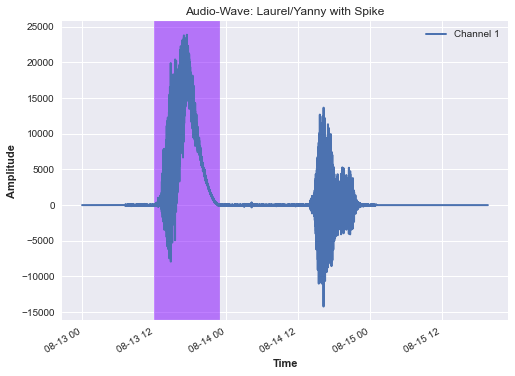

In [33]:
tss.plot()
plt.title("Audio-Wave: Laurel/Yanny with Spike")
plt.xlabel("Time")
plt.ylabel("Amplitude");

In [34]:
create_wav(tss.extract(), "laurel_spike_exp")

In [35]:
sound_file = './laurel_spike_exp.wav'
Audio(sound_file)

## Spiking -> Point Anomaly

#### 1. We create a TimeShop() object

In [36]:
tss = ts.edit()

#### 2. We select a part of the original time series. When only 1 value is set a single outlier will be created

In [37]:
tss.select(other=tss.time_series, start_time='2021-08-13 12:00:00', n_values=1)

#### 3. We transform the selected part to a spike sigal. We have to set the maximum value and the mode how to approach it.

In [38]:
tss.spiking(spike_value=30000, mode='lin')

#### 4. We chose the mode on how we want to put the selected and modified part back into the time series.

In [39]:
tss.replace()

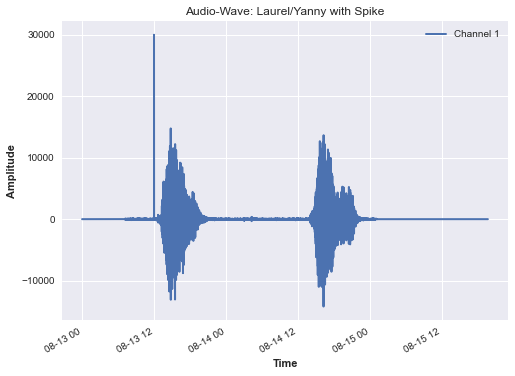

In [40]:
tss.plot()
plt.title("Audio-Wave: Laurel/Yanny with Spike")
plt.xlabel("Time")
plt.ylabel("Amplitude");

In [41]:
create_wav(tss.extract(), "laurel_spike_point")

In [42]:
sound_file = './laurel_spike_point.wav'
Audio(sound_file)

## Cropping a part of the TimeSeries

#### 1. Create TimeShop-object

In [43]:
tss = ts.edit()

#### 2. Copy the TimeSeries

In [44]:
tss.crop(start_time='2021-08-13 12:00:00', end_time='2021-08-14 12:00:00')

#### 3. Plotting the result

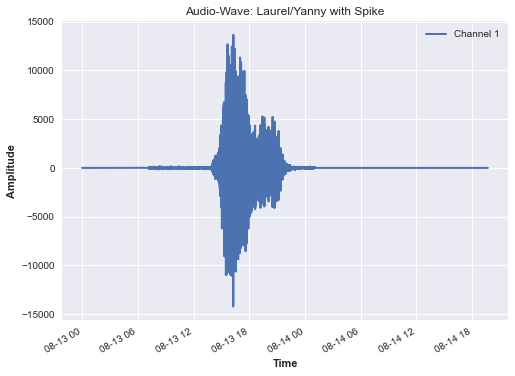

In [45]:
tss.plot()
plt.title("Audio-Wave: Laurel/Yanny with Spike")
plt.xlabel("Time")
plt.ylabel("Amplitude");

In [46]:
create_wav(tss.extract(), "laurel_crop")

In [47]:
sound_file = './laurel_crop.wav'
Audio(sound_file)

## Replacing sounds

#### 1. Create TimeShop-object

In [48]:
tss = ts.edit()

#### 2. We select a part of the original time series that we want to work on.

In [49]:
tss.select(other=tss.time_series, start_time='2021-08-13 12:00:00', end_time='2021-08-13 23:00:01')

#### 3. Shifting the extracted part to its new time stamp

In [50]:
tss.time_shifting(new_start='2021-08-14 09:00:00')

#### 4. Insert it back into the original time series

In [51]:
tss.insert()

#### 5. Plotting the result

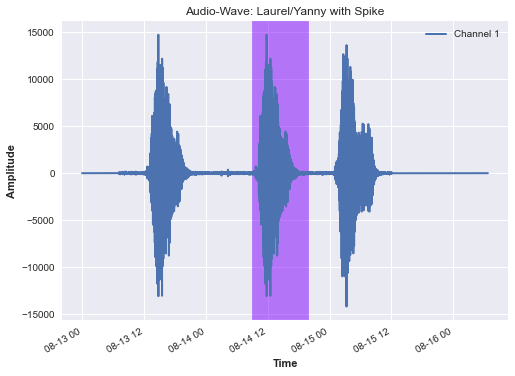

In [52]:
tss.plot()
plt.title("Audio-Wave: Laurel/Yanny with Spike")
plt.xlabel("Time")
plt.ylabel("Amplitude");

In [53]:
create_wav(tss.extract(), "laurel_copy")

In [54]:
sound_file = './laurel_copy.wav'
Audio(sound_file)

## Compression Hard Knee

#### 1. Create TimeShop-object

In [55]:
tss = ts.edit()

#### 2.Selecting the parts that should be compressed. It is most logical to use the threshold search.

In [56]:
tss.threshold_search(threshold=5000, operator=">=")

#### 3. Making the hard knee compression.

In [57]:
tss.hard_knee(factor=0.75, threshold=5000)

#### 4. Replacing the original with the compressed part

In [58]:
tss.replace()

#### 6. Repeat the same thing for the negative part

In [59]:
tss.threshold_search(threshold=-5000, operator="<=")
tss.hard_knee(factor=0.75, threshold=-5000)
tss.replace()

#### 7. Plotting the results 

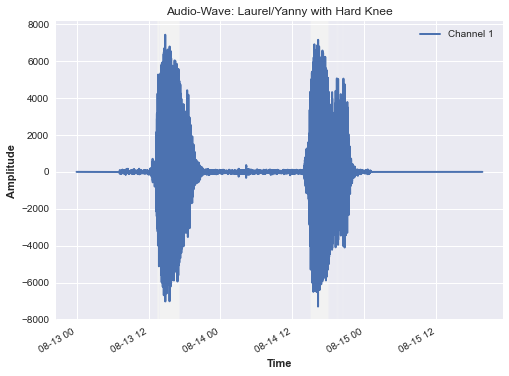

In [60]:
tss.plot()
plt.title("Audio-Wave: Laurel/Yanny with Hard Knee")
plt.xlabel("Time")
plt.ylabel("Amplitude");

In [61]:
create_wav(tss.extract(), "laurel_compress")

In [62]:
sound_file = './laurel_compress.wav'
Audio(sound_file)